In [29]:
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

from scipy.stats import binned_statistic
from common import make_env


plt.rcParams['figure.dpi'] = 256
plt.rcParams['text.usetex'] = True

/var/folders/v5/b2527n0x4zgb6khjjq0g22k40000gn/T/ipykernel_21295/2356807910.py:141: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


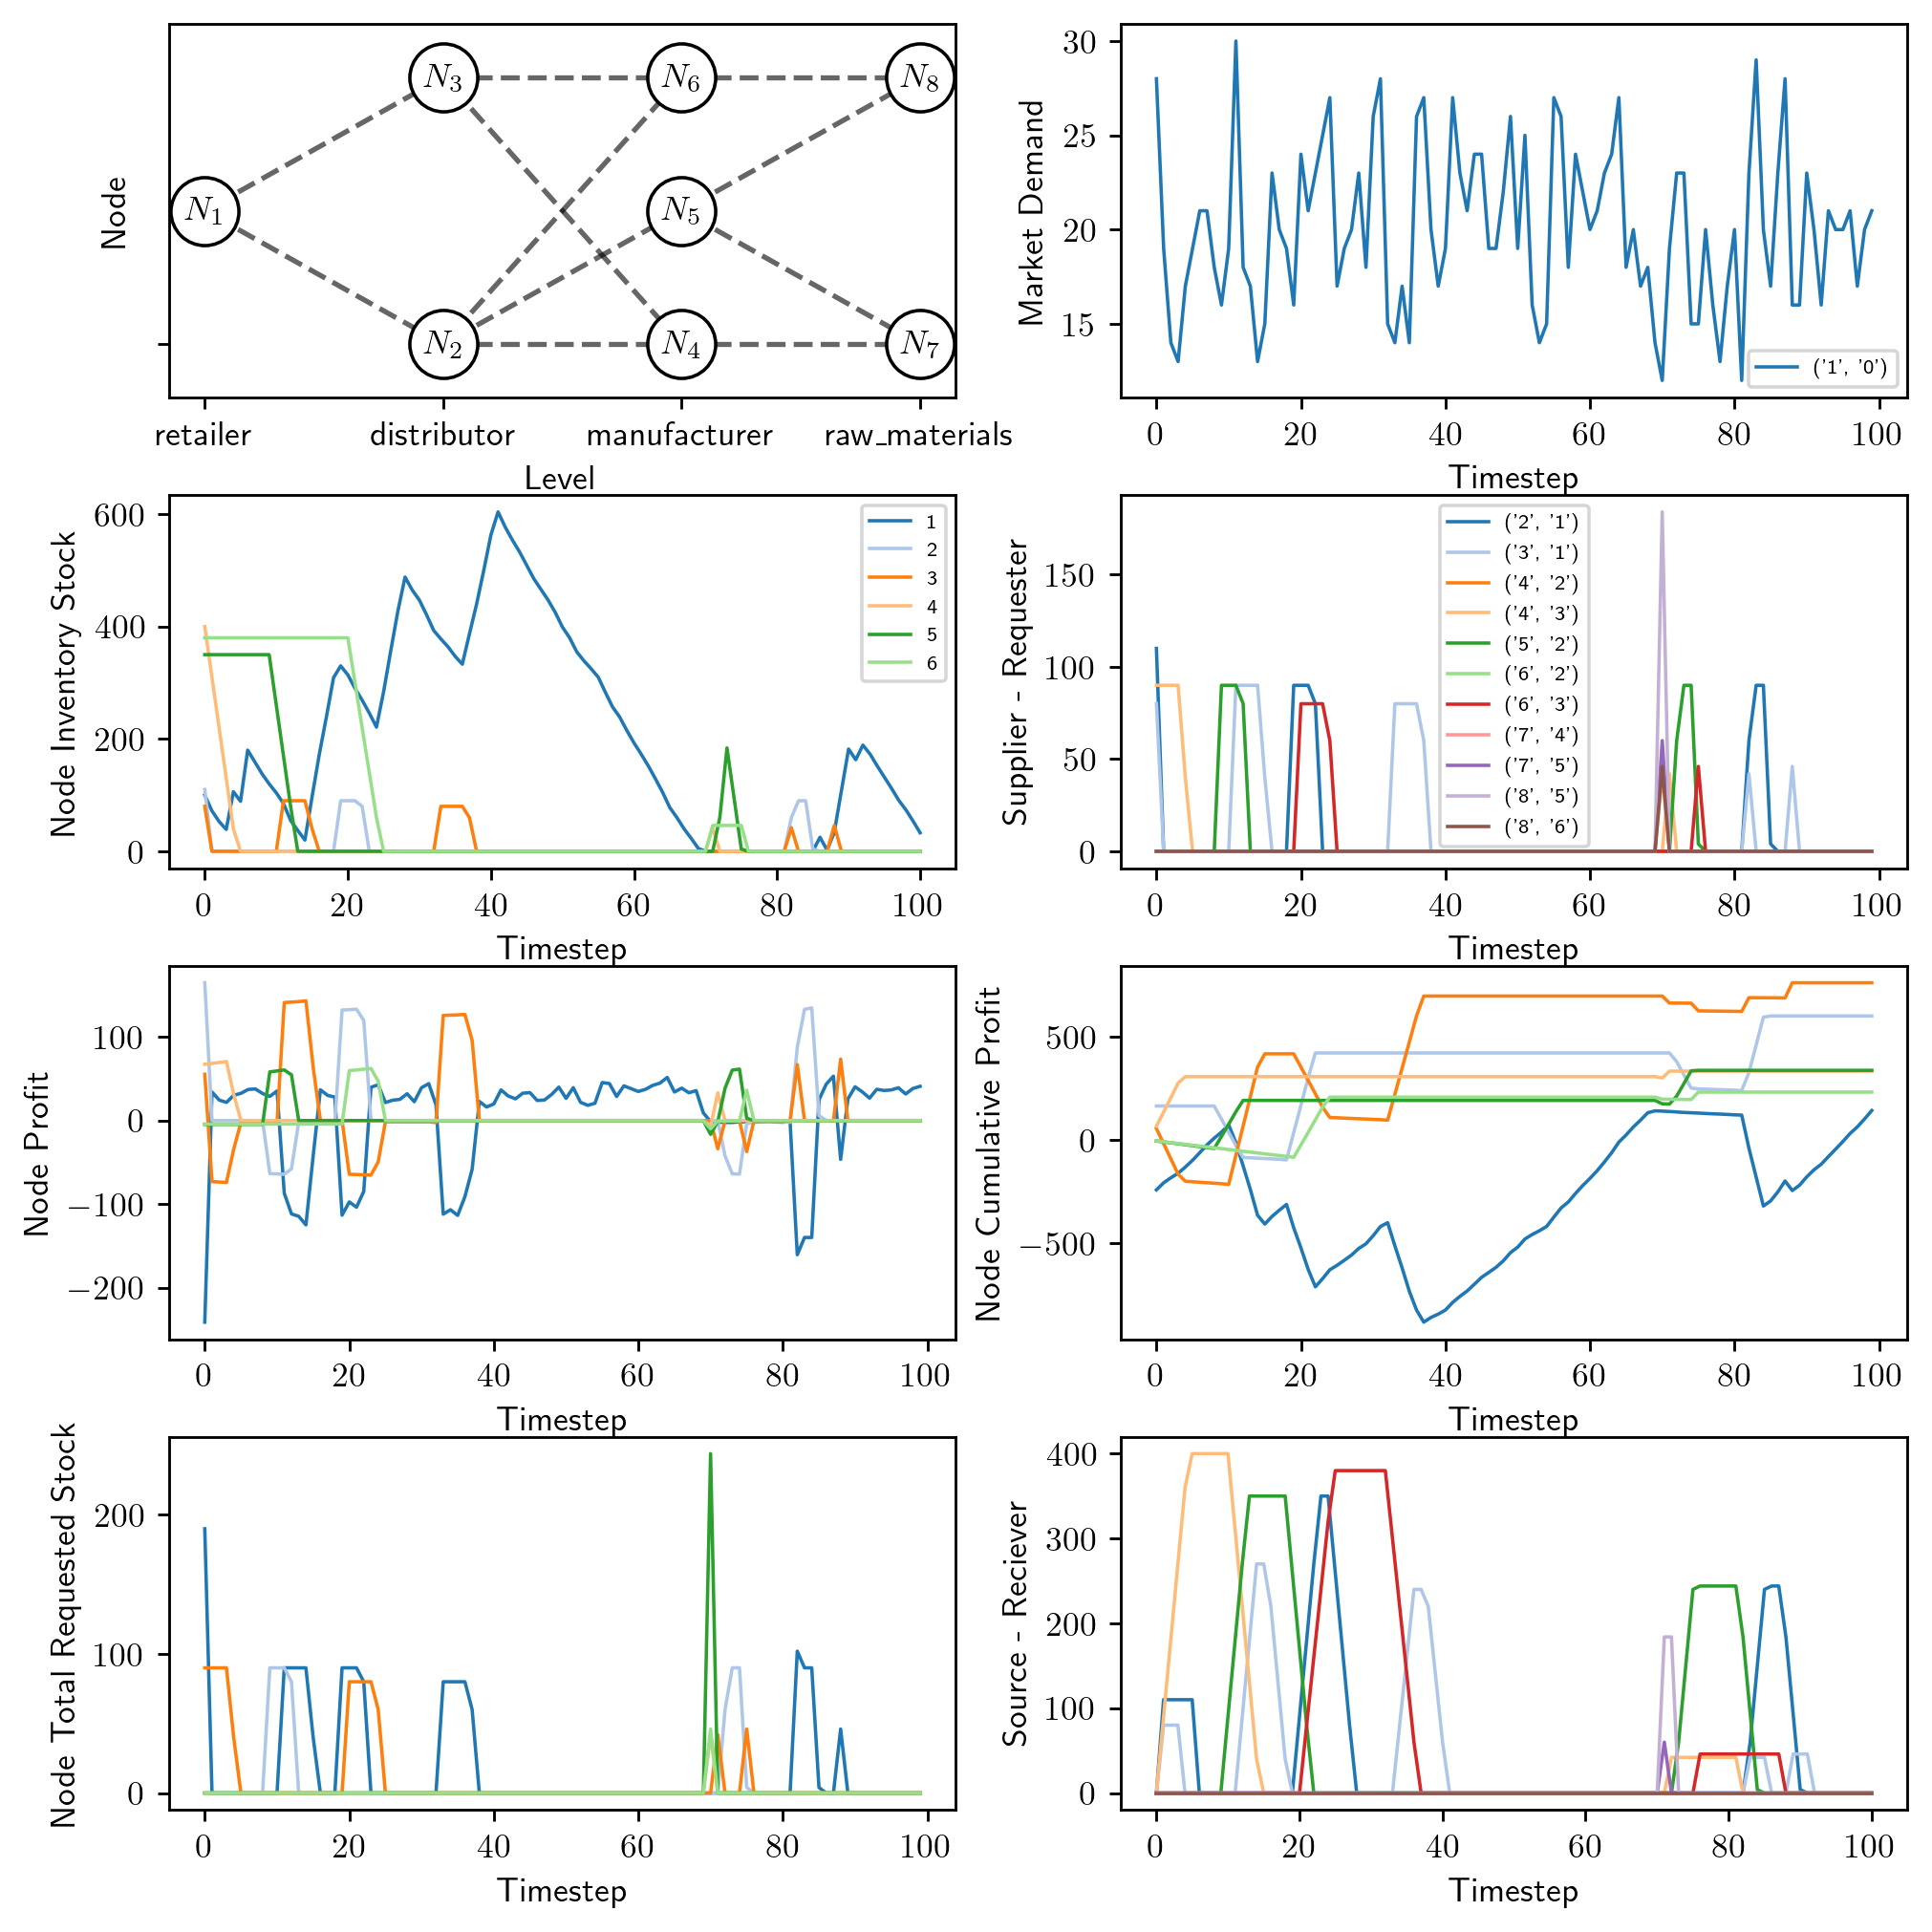

In [76]:
def plot_network_on_ax(env, ax):
    color = 'black'

    adjacency_matrix = np.vstack(env.graph.edges())
    # Set level colors
    level_col = {'retailer': 0,
                'distributor': 1,
                'manufacturer': 2,
                'raw_materials': 3}

    max_density = np.max([len(v) for v in env.levels.values()])
    node_coords = {}
    node_num = 1

    for i, (level, nodes) in enumerate(env.levels.items()):
        n = len(nodes)
        node_y = max_density / 2 if n == 1 else np.linspace(0, max_density, n)
        node_y = np.atleast_1d(node_y)
        ax.scatter(np.repeat(i, n), node_y, label=level, s=400, ec=color, fc='white', marker='o')

        for y in node_y:
            ax.annotate(r'$N_{}$'.format(node_num), xy=(i, y), ha='center', va='center', fontsize=10)
            node_coords[node_num] = (i, y)
            node_num += 1

    # Draw edges
    for node_num, v in node_coords.items():
        x, y = v
        sinks = adjacency_matrix[np.where(adjacency_matrix[:, 0]==node_num)][:, 1]
        for s in sinks:
            try:
                sink_coord = node_coords[s]
            except KeyError:
                continue
            
            x_ = np.hstack([x, sink_coord[0]])
            y_ = np.hstack([y, sink_coord[1]])
            ax.plot(x_, y_, color=color, linestyle='--', alpha=0.6, zorder=-10)

    ax.set_ylabel('Node')
    ax.set_yticks([0], [''])
    ax.set_xlabel('Level')
    ax.set_xticks(np.arange(len(env.levels)), [k for k in env.levels.keys()])
    ax.set_ymargin(0.2)


def plot_network(env_name):
    fig, ax = plt.subplots(nrows=1, ncols=1)
    fig.set_size_inches(8, 4)

    env = make_env(env_name)
    plot_network_on_ax(env, ax)

    save_dir = f'./figures/{env_name}/'

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    fig.savefig(save_dir + 'network.pdf')
    fig.show()


def plot_episode(env_name, algo_name, name):
    save_path = f'./data/{env_name}/{algo_name}/{name}/'
    env = make_env(env_name)

    fig, ax = plt.subplots(nrows=4, ncols=2)
    fig.set_size_inches(8, 8)

    plot_network_on_ax(env, ax[0,0])

    df_names = ['D', 'X', 'R', 'P', 'Y']
    df_headers = [[0,1], [0], [0,1], [0], [0,1]]
    data = {}

    for i, df_name in enumerate(df_names):
        df = pd.read_csv(save_path + f'eval/3/{df_name}.csv', index_col=[0], header=df_headers[i])
        data[df_name] = df

    cmap = plt.get_cmap('tab20')


    for i, retailer_market in enumerate(data['D'].columns):
        retailer, market = retailer_market
        ax[0,1].plot(data['D'][retailer_market], linewidth=1.0, label=retailer_market)

    for i, node_num in enumerate(data['X'].columns):
        ax[1,0].plot(data['X'][node_num], linewidth=1.0, label=node_num, color=cmap(i))

    for i, supplier_requester in enumerate(data['R'].columns):
        supplier, requester = supplier_requester
        ax[1,1].plot(data['R'][supplier_requester], linewidth=1.0, label=supplier_requester, color=cmap(i))

    for i, node_num in enumerate(data['P'].columns):
        ax[2,0].plot(data['P'][node_num], linewidth=1.0, label=node_num, color=cmap(i))
        ax[2,1].plot(np.cumsum(data['P'][node_num]), linewidth=1.0, label=node_num, color=cmap(i))

    Rtot = data['R'].groupby('Requester', axis=1).sum()

    for i, node_num in enumerate(Rtot.columns):
        ax[3,0].plot(Rtot[node_num], linewidth=1.0, label=node_num, color=cmap(i))

    for i, source_reciever in enumerate(data['Y'].columns):
        source, reciever = source_reciever
        ax[3,1].plot(data['Y'][source_reciever], linewidth=1.0, label=source_reciever, color=cmap(i))

    ax[0,1].legend(fontsize=6)
    ax[1,0].legend(fontsize=6)
    ax[1,1].legend(fontsize=6)
    
    ax[0,1].set_xlabel('Timestep')
    ax[0,1].set_ylabel('Market Demand')

    ax[1,0].set_xlabel('Timestep')
    ax[1,0].set_ylabel('Node Inventory Stock')

    ax[1,1].set_xlabel('Timestep')
    ax[1,1].set_ylabel('Supplier - Requester')

    ax[2,0].set_xlabel('Timestep')
    ax[2,0].set_ylabel('Node Profit')

    ax[2,1].set_xlabel('Timestep')
    ax[2,1].set_ylabel('Node Cumulative Profit')

    ax[3,0].set_xlabel('Timestep')
    ax[3,0].set_ylabel('Node Total Requested Stock')

    ax[3,1].set_xlabel('Timestep')
    ax[3,1].set_ylabel('Source - Reciever')


    fig.tight_layout(h_pad=0.0, w_pad=0.0)

    save_dir = f'./figures/{env_name}/'

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    fig.savefig(save_dir + 'episode.pdf')
    fig.show()

#plot_network('NetworkManagement-v1-100')
plot_episode('NetworkManagement-v1-100', 'ARS', 'default')


/var/folders/v5/b2527n0x4zgb6khjjq0g22k40000gn/T/ipykernel_21295/2142802801.py:71: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


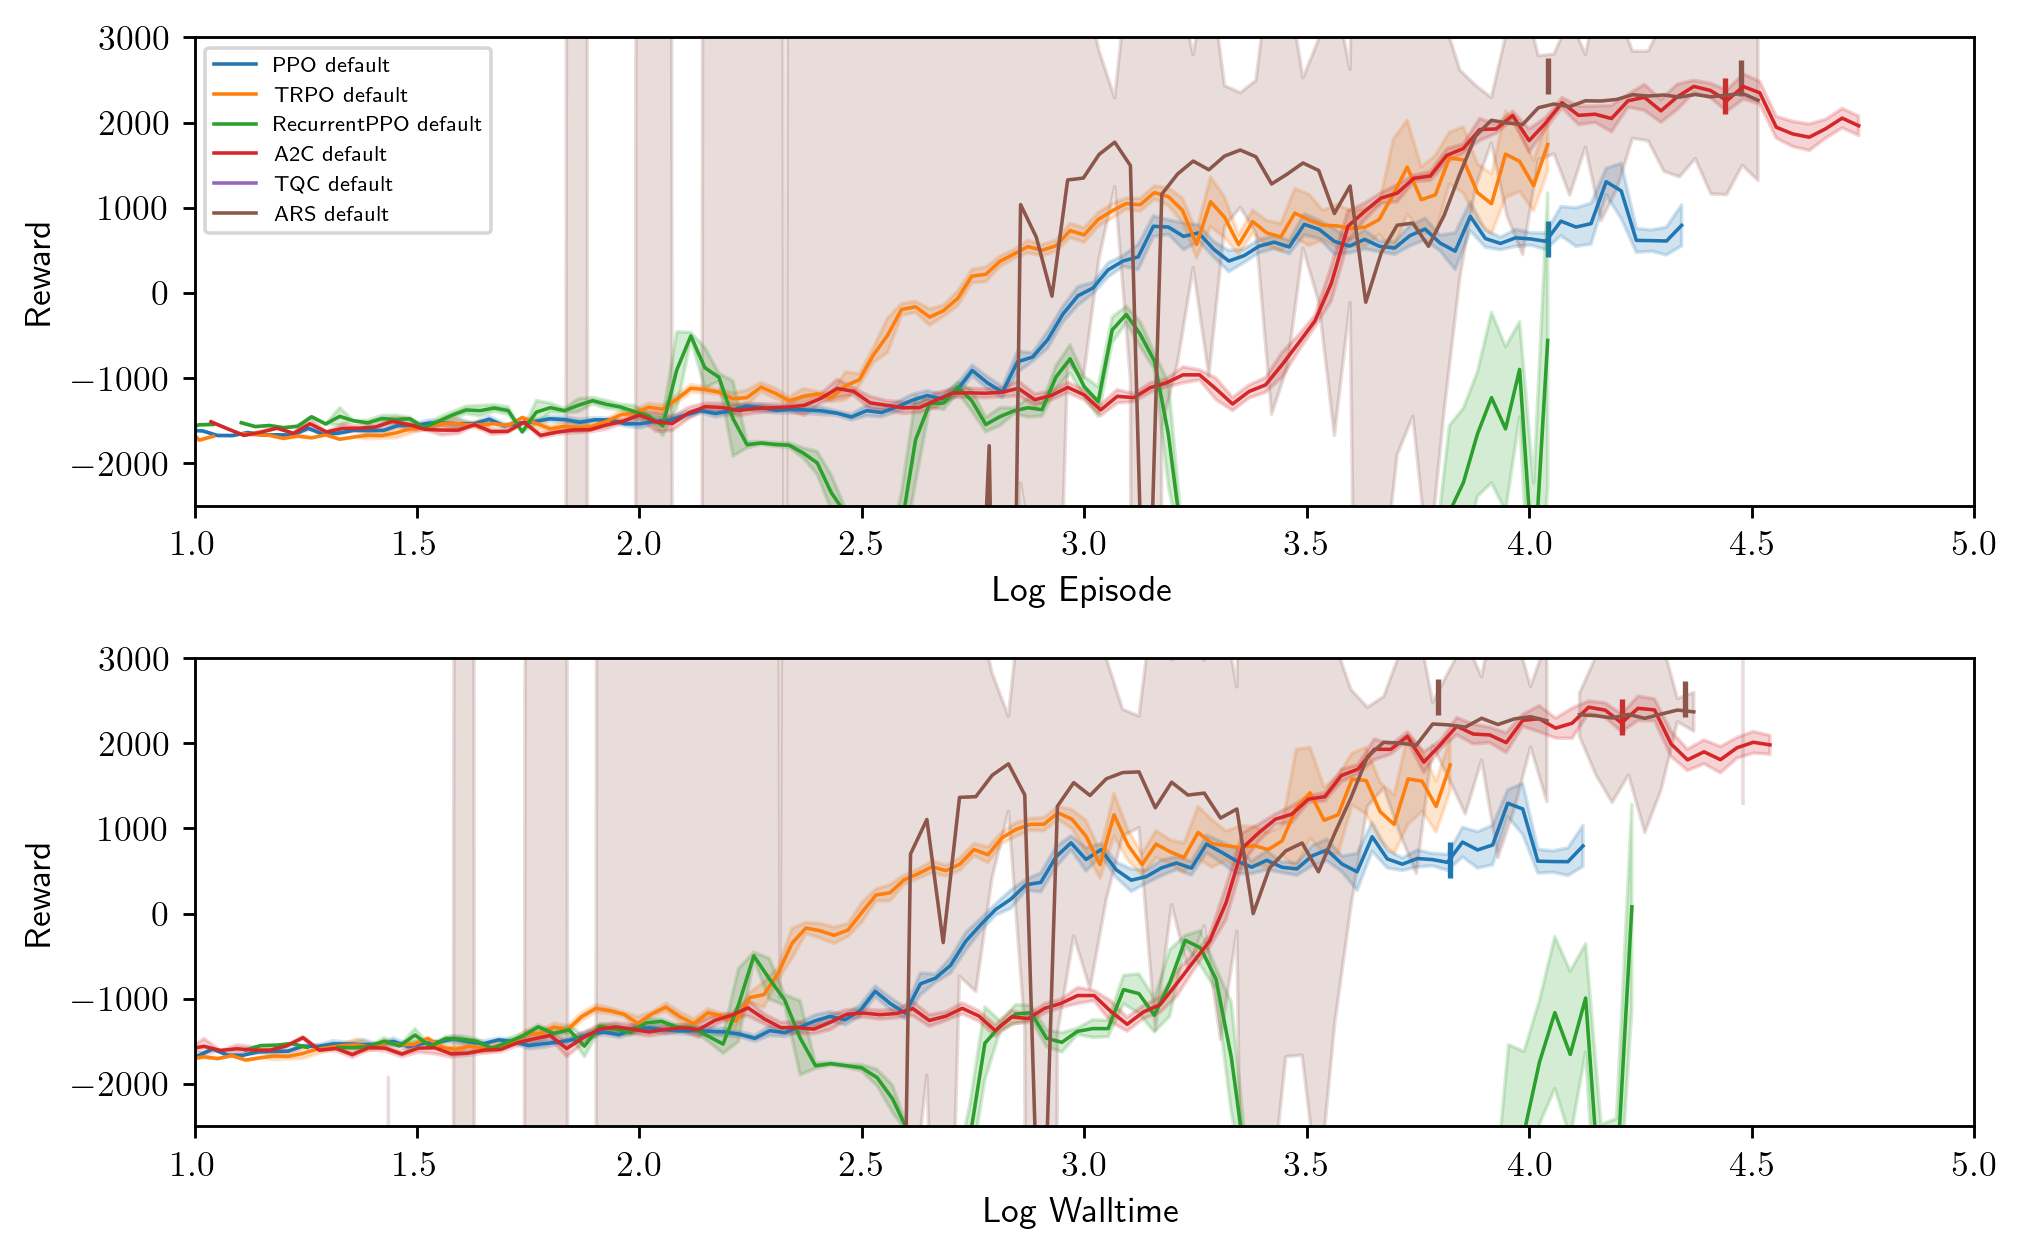

In [95]:
def plot_training_curves(env_name, model_names, xlims, ylims):
    fig, ax = plt.subplots(nrows=2, ncols=1)
    fig.set_size_inches(8, 5)

    linewidth = 1.0
    alpha = 0.2

    cmap = plt.get_cmap('tab10')

    for i, model_name in enumerate(model_names):
        algorithm_name, name = model_name
        data = pd.read_csv(f'./data/{env_name}/{algorithm_name}/{name}/monitor.csv', skiprows=1)

        num_bins = 128
        ep_binned_mean_r = binned_statistic(np.log10(np.arange(len(data['r'])) + 1), data['r'], 'mean', num_bins)
        ep_binned_std_r = binned_statistic(np.log10(np.arange(len(data['r'])) + 1), data['r'], 'std', num_bins)
        
        ax[0].plot(ep_binned_mean_r.bin_edges[1:], ep_binned_mean_r.statistic, 
            linewidth=linewidth, label=algorithm_name + ' ' + name, color=cmap(i))
        ax[0].fill_between(ep_binned_mean_r.bin_edges[1:], ep_binned_mean_r.statistic + ep_binned_std_r.statistic,
                           ep_binned_mean_r.statistic - ep_binned_std_r.statistic, color=cmap(i), alpha=alpha)
        
        r = data['r'].to_numpy()
        t_raw = data['t'].to_numpy()
        t = t_raw.copy()
        restart_idxs = np.where(np.diff(t) < 0)[0]
        restart_ts = np.zeros(len(restart_idxs))
        restart_rs = np.zeros(len(restart_idxs))

        for j, idx in enumerate(restart_idxs):
            t[idx+1:] = t[idx+1:] + t[idx]
            restart_ts[j] = t[idx]
            restart_rs[j] = r[idx]

        num_bins = 128
        t_binned_mean_r = binned_statistic(np.log10(t), r, 'mean', num_bins)
        t_binned_std_r = binned_statistic(np.log10(t), r, 'std', num_bins)

        ax[1].plot(t_binned_mean_r.bin_edges[1:], t_binned_mean_r.statistic, 
            linewidth=linewidth, label=algorithm_name + ' ' + name, color=cmap(i))
        ax[1].fill_between(t_binned_mean_r.bin_edges[1:], t_binned_mean_r.statistic + t_binned_std_r.statistic,
                           t_binned_mean_r.statistic - t_binned_std_r.statistic, color=cmap(i), alpha=alpha)
        
        ax[0].scatter(np.log10(restart_idxs), restart_rs, color=cmap(i), s=100, marker='|')
        ax[1].scatter(np.log10(restart_ts), restart_rs, color=cmap(i), s=100, marker='|')

        # ax[1].plot(data['t'], data['r'], linewidth=linewidth, alpha=0.4, color=colors[i]))

    ax[0].legend(fontsize=6)

    ax[0].set_xlabel('Log Episode')
    ax[0].set_ylabel('Reward')

    ax[1].set_xlabel('Log Walltime')
    ax[1].set_ylabel('Reward')

    ax[0].set_xlim(*xlims)
    ax[1].set_xlim(*xlims)

    ax[0].set_ylim(*ylims)
    ax[1].set_ylim(*ylims)

    fig.tight_layout()

    save_dir = f'./figures/{env_name}/'

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    fig.savefig(save_dir + 'training.pdf')
    fig.show()

models = [('PPO', 'default'), ('TRPO', 'default'), ('RecurrentPPO', 'default'), ('A2C', 'default'), ('TQC', 'default'), ('ARS', 'default')]

plot_training_curves('NetworkManagement-v1-100', models, (1, 5), (-2500, 3000))
#plot_training_curves('InvManagement-v1', models)
